In [1]:
## edited David Ding, run on google colab

#ProteinMPNN
This notebook is intended as a quick demo, more features to come!

In [ ]:
# import my own functions in google colab
from google.colab import drive
import sys
import importlib

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/src/')

import myTools
importlib.reload(myTools)
from myTools import hamming, complement
import myPlot
importlib.reload(myPlot)
import myPlot as mp
import pandas as pd

Mounted at /content/drive


In [ ]:
#title Clone github repo
import json, time, os, sys, glob

if not os.path.isdir("ProteinMPNN"):
  os.system("git clone -q https://github.com/dauparas/ProteinMPNN.git")
sys.path.append('/content/ProteinMPNN/')
sys.path.append('/content/ProteinMPNN/vanilla_proteinmpnn')

In [ ]:
#title Setup Model
import matplotlib.pyplot as plt
import shutil
import warnings
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "v_48_002" #param ["v_48_002", "v_48_010", "v_48_020", "v_48_030"]


backbone_noise=0.00    # Standard deviation of Gaussian noise to add to backbone atoms

path_to_model_weights='/content/ProteinMPNN/vanilla_model_weights'          
hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device) 
print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, 
                    node_features=hidden_dim, 
                    edge_features=hidden_dim, 
                    hidden_dim=hidden_dim, 
                    num_encoder_layers=num_layers, 
                    num_decoder_layers=num_layers, 
                    augment_eps=backbone_noise, 
                    k_neighbors=checkpoint['num_edges'])
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

Number of edges: 48
Training noise level: 0.02A
Model loaded


In [ ]:

import re
from google.colab import files
import numpy as np

homomer = False #param {type:"boolean"}

num_seqs = 8 #param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

#markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.
sampling_temp = "0.1" #param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]


save_score=!                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=!                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='/content/drive/MyDrive/ex62_ta_design/protein_mpnn/'                    # Path to a folder to output sequences, e.g. /home/out/
folder_for_outputs = out_folder

jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True

##############################################################

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None # created downstream
fixed_positions_dict = {
    'bio_all_rm_non_chain_dd1_header': 
    {'A': [1,2,3,4], 
     'C': [2,3,4,5], 
     'E': [1,2,3,4], 
     'G': [2,3,4,5]}
     } #None # ?{"5TTA": {"A": [1, 2, 3, 7, 8, 9, 22, 25, 33], "B": []}
pssm_dict = None #
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
print('----pdb file from pymol with modified header: ----')
## parsing the chains
designed_chain = "A,C,E,G" #param {type:"string"}
fixed_chain = "B,D,F,H" #param {type:"string"}
if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")
if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")
chain_list = list(set(designed_chain_list + fixed_chain_list))


# creating the dataset
pdb_path = '/content/drive/MyDrive/ex62_ta_design/pdb_5cegs/bio_all_rm_non_chain_dd1_header.pdb'
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)

print('pdb_dict_list',pdb_dict_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)
print(chain_id_dict)

for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

##############################################

# creating all the ties within antitoxin chains and toxin chains
def make_tied_pos_dict_dd():
    # making a tied pos dic like in their github
    #{"5TTA": [], "3LIS": [{"A": [1], "B": [1]}, {"A": [2], "B": [2]}, {"A": [3], "B": [3]}, {"A": [4], "B": [4]}, {"A": [5], "B": [5]}, {"A": [6], "B": [6]}, {"A": [7], "B": [7]}, {"A": [8], "B": [8]}, {"A": [9], "B": [9]}, {"A": [10], "B": [10]}, {"A": [11], "B": [11]}, {"A": [12], "B": [12]}, {"A": [13], "B": [13]}, {"A": [14], "B": [14]}, {"A": [15], "B": [15]}, {"A": [16], "B": [16]}, {"A": [17], "B": [17]}, {"A": [18], "B": [18]}, {"A": [19], "B": [19]}, {"A": [20], "B": [20]}, {"A": [21], "B": [21]}, {"A": [22], "B": [22]}, {"A": [23], "B": [23]}, {"A": [24], "B": [24]}, {"A": [25], "B": [25]}, {"A": [26], "B": [26]}, {"A": [27], "B": [27]}, {"A": [28], "B": [28]}, {"A": [29], "B": [29]}, {"A": [30], "B": [30]}, {"A": [31], "B": [31]}, {"A": [32], "B": [32]}, {"A": [33], "B": [33]}, {"A": [34], "B": [34]}, {"A": [35], "B": [35]}, {"A": [36], "B": [36]}, {"A": [37], "B": [37]}, {"A": [38], "B": [38]}, {"A": [39], "B": [39]}, {"A": [40], "B": [40]}, {"A": [41], "B": [41]}, {"A": [42], "B": [42]}, {"A": [43], "B": [43]}, {"A": [44], "B": [44]}, {"A": [45], "B": [45]}, {"A": [46], "B": [46]}, {"A": [47], "B": [47]}, {"A": [48], "B": [48]}, {"A": [49], "B": [49]}, {"A": [50], "B": [50]}, {"A": [51], "B": [51]}, {"A": [52], "B": [52]}, {"A": [53], "B": [53]}, {"A": [54], "B": [54]}, {"A": [55], "B": [55]}, {"A": [56], "B": [56]}, {"A": [57], "B": [57]}, {"A": [58], "B": [58]}, {"A": [59], "B": [59]}, {"A": [60], "B": [60]}, {"A": [61], "B": [61]}, {"A": [62], "B": [62]}, {"A": [63], "B": [63]}, {"A": [64], "B": [64]}, {"A": [65], "B": [65]}, {"A": [66], "B": [66]}, {"A": [67], "B": [67]}, {"A": [68], "B": [68]}, {"A": [69], "B": [69]}, {"A": [70], "B": [70]}, {"A": [71], "B": [71]}, {"A": [72], "B": [72]}, {"A": [73], "B": [73]}, {"A": [74], "B": [74]}, {"A": [75], "B": [75]}, {"A": [76], "B": [76]}, {"A": [77], "B": [77]}, {"A": [78], "B": [78]}, {"A": [79], "B": [79]}, {"A": [80], "B": [80]}, {"A": [81], "B": [81]}, {"A": [82], "B": [82]}, {"A": [83], "B": [83]}, {"A": [84], "B": [84]}, {"A": [85], "B": [85]}, {"A": [86], "B": [86]}, {"A": [87], "B": [87]}, {"A": [88], "B": [88]}, {"A": [89], "B": [89]}, {"A": [90], "B": [90]}, {"A": [91], "B": [91]}, {"A": [92], "B": [92]}, {"A": [93], "B": [93]}, {"A": [94], "B": [94]}, {"A": [95], "B": [95]}, {"A": [96], "B": [96]}]}
    # assuming I'm starting with counting the first amino acid as 1 in the sequence
    '''
    # it should look like this
    tied_pos_dict= { 'bio_all_rm_non_chain_dd1_header': 
                    [
                    {'A': [1], 'C':[2], 'E':[1], 'G':[2]}, # antitoxins until, 
                    {'A': [84], 'C':[85], 'E':[84], 'G':[85]},
                    
                    {'B': [3], 'D':[1], 'F':[3], 'H':[1]}, # toxins until:
                    {'B': [103], 'D':[101], 'F':[103], 'H':[101]}
                    ]
                    }
    '''
    # antitoxins A,C,E,G
    # toxins B, D, F, H

    seq_keys = [k for k in pdb_dict_list[0].keys() if k.startswith('seq_chain')]
    seq_key_to_seq = dict(zip(seq_keys, [pdb_dict_list[0][k] for k in seq_keys]))

    '''
    for c, s in seq_key_to_seq.items():
        if c[-1] in ['A', 'C', 'E', 'G']:
            print(c, len(s))
            print(s)

    for c, s in seq_key_to_seq.items():
        if c[-1] in ['B', 'D', 'F', 'H']:
            print(c, len(s))
            print(s)
    '''
   

    # creat antitoxin list of dictionaries:
    at_list_dicts = []
    for i in range(1,85):
        at_list_dicts.append({'A': [i], 'C':[i+1], 'E':[i], 'G':[i+1]})

    t_list_dicts = []
    for i in range(3,104):
        t_list_dicts.append({'B': [i], 'D':[i-2], 'F':[i], 'H':[i-2]})

    #print(at_list_dicts)
    #print(t_list_dicts)
    #print(seq_key_to_seq)

    tied_pos_dict = { 'bio_all_rm_non_chain_dd1_header': at_list_dicts + t_list_dicts}

    return tied_pos_dict

tied_positions_dict = make_tied_pos_dict_dd()


----pdb file from pymol with modified header: ----
pdb_dict_list [{'seq_chain_E': 'NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTE', 'coords_chain_E': {'N_chain_E': [[-5.93, -53.112, -55.965], [-9.055, -53.198, -57.35], [-11.611, -55.721, -57.375], [-13.925, -57.239, -59.42], [-16.943, -59.1, -59.225], [-19.55, -61.417, -60.087], [-22.405, -61.972, -58.286], [-24.951, -63.898, -56.574], [-27.709, -62.928, -54.827], [-30.476, -63.011, -52.446], [-33.858, -62.054, -53.366], [-35.051, -60.519, -51.406], [-32.855, -59.629, -49.912], [-31.596, -58.067, -51.888], [-33.481, -56.102, -52.194], [-33.498, -54.706, -49.746], [-30.888, -53.77, -49.722], [-31.005, -52.014, -51.91], [-32.9, -50.2, -50.909], [-31.393, -49.081, -48.822], [-29.32, -47.806, -50.142], [-30.794, -45.982, -51.75], [-31.833, -44.405, -49.74], [-29.647, -43.046, -48.916], [-27.824, -44.089, -47.121], [-25.713, -45.526, -48.096], [-23.517, -45.341, -50.974], [-23.417, -47.141, -53.149], [

- goal:

- read a pdb file of 8 chains

- make predictions of mutations for whole antitoxin, as well as a subset of positions at different temperatures




In [ ]:

def generate_seqs(dataset_valid,
                temp,
                fixed_positions_dict,
                BATCH_COPIES, 
                NUM_BATCHES,
                device, 
                chain_id_dict, 
                omit_AA_dict, 
                tied_positions_dict, 
                pssm_dict, 
                bias_by_res_dict, 
                pssm_threshold, 
                omit_AAs_np,
                bias_AAs_np,
                pssm_multi,
                pssm_log_odds_flag,
                pssm_bias_flag
                  ):
    '''
    returns a list of generated sequences that matches the wt sequence of that chain A
    '''
    with torch.no_grad():
        print('Generating sequences...')
        for ix, protein in enumerate(dataset_valid):
            score_list = []
            all_probs_list = []
            all_log_probs_list = []
            S_sample_list = []
            batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
            X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, 
                                                                                                                                                                                                                                                                                                                            device, 
                                                                                                                                                                                                                                                                                                                            chain_id_dict, 
                                                                                                                                                                                                                                                                                                                            fixed_positions_dict, 
                                                                                                                                                                                                                                                                                                                            omit_AA_dict, 
                                                                                                                                                                                                                                                                                                                            tied_positions_dict, 
                                                                                                                                                                                                                                                                                                                            pssm_dict, 
                                                                                                                                                                                                                                                                                                                            bias_by_res_dict)
            pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
            name_ = batch_clones[0]['name']

            randn_1 = torch.randn(chain_M.shape, device=X.device)
            log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S, log_probs, mask_for_loss)
            native_score = scores.cpu().data.numpy()

            for j in range(NUM_BATCHES):
                randn_2 = torch.randn(chain_M.shape, device=X.device)
                if tied_positions_dict == None:
                    sample_dict = model.sample(X, 
                                            randn_2, 
                                            S, 
                                            chain_M, 
                                            chain_encoding_all, 
                                            residue_idx, 
                                            mask=mask, 
                                            temperature=temp, 
                                            omit_AAs_np=omit_AAs_np, 
                                            bias_AAs_np=bias_AAs_np, 
                                            chain_M_pos=chain_M_pos, 
                                            omit_AA_mask=omit_AA_mask, 
                                            pssm_coef=pssm_coef, 
                                            pssm_bias=pssm_bias, 
                                            pssm_multi=pssm_multi, 
                                            pssm_log_odds_flag=bool(pssm_log_odds_flag), 
                                            pssm_log_odds_mask=pssm_log_odds_mask, 
                                            pssm_bias_flag=bool(pssm_bias_flag), 
                                            bias_by_res=bias_by_res_all)
                    S_sample = sample_dict["S"] 
                else:
                    sample_dict = model.tied_sample(X, 
                                                    randn_2, 
                                                    S, 
                                                    chain_M, 
                                                    chain_encoding_all, 
                                                    residue_idx, 
                                                    mask=mask, 
                                                    temperature=temp, 
                                                    omit_AAs_np=omit_AAs_np, 
                                                    bias_AAs_np=bias_AAs_np, 
                                                    chain_M_pos=chain_M_pos, 
                                                    omit_AA_mask=omit_AA_mask, 
                                                    pssm_coef=pssm_coef, 
                                                    pssm_bias=pssm_bias, 
                                                    pssm_multi=pssm_multi, 
                                                    pssm_log_odds_flag=bool(pssm_log_odds_flag), 
                                                    pssm_log_odds_mask=pssm_log_odds_mask, 
                                                    pssm_bias_flag=bool(pssm_bias_flag), 
                                                    tied_pos=tied_pos_list_of_lists_list[0], 
                                                    tied_beta=tied_beta, 
                                                    bias_by_res=bias_by_res_all)
                    S_sample = sample_dict["S"]
                # Compute scores
                log_probs = model(X, 
                                S_sample, 
                                mask, 
                                chain_M*chain_M_pos, 
                                residue_idx, 
                                chain_encoding_all, 
                                randn_2, 
                                use_input_decoding_order=True, 
                                decoding_order=sample_dict["decoding_order"])
                
                mask_for_loss = mask*chain_M*chain_M_pos
                scores = _scores(S_sample, log_probs, mask_for_loss)
                scores = scores.cpu().data.numpy()
                all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
                all_log_probs_list.append(log_probs.cpu().data.numpy())
                S_sample_list.append(S_sample.cpu().data.numpy())
                for b_ix in range(BATCH_COPIES):
                    masked_chain_length_list = masked_chain_length_list_list[b_ix]
                    masked_list = masked_list_list[b_ix]
                    seq_recovery_rate = torch.sum(
                        torch.sum(
                            torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                    seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                    score = scores[b_ix]
                    score_list.append(score)
                    native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                    if b_ix == 0 and j==0 and temp==temperatures[0]:
                        start = 0
                        end = 0
                        list_of_AAs = []
                        for mask_l in masked_chain_length_list:
                            end += mask_l
                            list_of_AAs.append(native_seq[start:end])
                            start = end
                        native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                        l0 = 0
                        for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                            l0 += mc_length
                            native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                            l0 += 1
                        sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                        print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                        sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                        print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                        native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                        line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.format(name_, 
                                                                                                                native_score_print, 
                                                                                                                print_visible_chains, 
                                                                                                                print_masked_chains, 
                                                                                                                model_name, 
                                                                                                                native_seq
                                                                                                                )
                        #print(line.rstrip())
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(seq[start:end])
                        start = end

                    seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        seq = seq[:l0] + '/' + seq[l0:]
                        l0 += 1
                    score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                    seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                    line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.format(temp,b_ix,score_print,seq_rec_print,seq)
                    #print(line.rstrip())


    all_probs_concat = np.concatenate(all_probs_list)
    all_log_probs_concat = np.concatenate(all_log_probs_list)
    S_sample_concat = np.concatenate(S_sample_list)

    # decode sequences
    pos_to_alphabet = dict(zip(range(len(alphabet)), alphabet))

    wt_seq = pdb_dict_list[0]['seq_chain_A']
    designed_seqs = []
    for i in range(S_sample_concat.shape[0]):
        s= S_sample_concat[i,:]
        seq = ''.join([pos_to_alphabet[k] for k in s])
        at_chain_a = seq[:85]
        designed_seqs.append(at_chain_a)
        #print(at_chain_a)
        print(hamming(at_chain_a, wt_seq))
    return designed_seqs

def write_seqs_fasta(list_seqs, pout):
    with open(pout, 'w') as fout:
        for i,s in enumerate(list_seqs):
            fout.write('>s{}\n'.format(i))
            fout.write(s+'\n')


In [ ]:

# generate seqs for only the 10 positions: L47, D51, I52, R54, L55, F73, R77, E79, A80, R81 # M0 indexed. so subtract 1 to calculate to pmpnn's chain A+E maNVE, and don't subtract for chain C+G
# for 3 positions: D60, K63, E79 # M0 indexed, as above.
# show the hamming distances

m0_var_pos_10x = [47, 51, 52, 54, 55, 73, 77, 79, 80, 81] # for chain C+G
chAE_var_pos_10x = [p-1 for p in m0_var_pos_10x]

m0_var_pos_3x = [60,63,79] # for chain C+G
chAE_var_pos_3x = [p-1 for p in m0_var_pos_3x]

fixed_positions_dict_3pos_lib = {'bio_all_rm_non_chain_dd1_header':
                                  {'A':[p for p in list(range(1,86)) if p not in chAE_var_pos_3x],
                                   'C':[p for p in list(range(1,86)) if p not in m0_var_pos_3x],
                                   'E':[p for p in list(range(1,86)) if p not in chAE_var_pos_3x],
                                   'G':[p for p in list(range(1,86)) if p not in m0_var_pos_3x]
                                   }
                                  }
fixed_positions_dict_10pos_lib= {'bio_all_rm_non_chain_dd1_header':
                                  {'A':[p for p in list(range(1,86)) if p not in chAE_var_pos_10x],
                                   'C':[p for p in list(range(1,86)) if p not in m0_var_pos_10x],
                                   'E':[p for p in list(range(1,86)) if p not in chAE_var_pos_10x],
                                   'G':[p for p in list(range(1,86)) if p not in m0_var_pos_10x]
                                   }
                                  }

fixed_positions_dict_n_term= {'bio_all_rm_non_chain_dd1_header':
                                  {'A':list(range(1,43)) ,
                                   'C':list(range(2,44)),
                                   'E':list(range(1,43)),
                                   'G':list(range(2,44))
                                   }
                                  }


# scoring seqs

In [ ]:
data_dir = '/content/drive/MyDrive/ex62_ta_design/pard_data_march2022/data/'
df_10pos = pd.read_csv(data_dir + 'df_10pos_no_stop.csv')
df_3pos = pd.read_csv(data_dir + 'df_mut_all_aa.csv') 
df_4pos = pd.read_csv(data_dir + 'df_mut_chris_no_stop_nonan.csv') 



In [ ]:
at_ch1_seq = 'NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTE'
at_ch2_seq = 'ANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLT'

#sanity for offsets right?
mut_key_m1 = df_10pos.muts_m1[0]
print(mut_key_m1)
for m in mut_key_m1.split(':'):
    wt_aa = m[0]
    pos = int(m[1:-1])
    mut_aa = m[-1]
    print(at_ch1_seq[pos-1])
    assert at_ch1_seq[pos-3] == wt_aa
    assert at_ch2_seq[pos-2] == wt_aa

def get_full_str(at_ch_seq, offset, mutkey):
    # take a mutkey and mutate the correct positions in the sequence
    # use offset of 3
    #at_ch1_seq = 'NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTE'
    # use offset of 2
    #at_ch2_seq = 'ANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLT'

    list_at_ch_seq = list(at_ch_seq)
    for m in mutkey.split(':'):
        wt_aa = m[0]
        pos = int(m[1:-1])
        mut_aa = m[-1]
        #print(at_ch1_seq[pos-1])
        assert at_ch_seq[pos-offset] == wt_aa

        list_at_ch_seq[pos-offset] = mut_aa
    return ''.join(list_at_ch_seq)

def get_full_S_string(mutkey):
    # 
    at_1_mut_seq = get_full_str(at_ch1_seq, 3, mutkey)
    at_2_mut_seq = get_full_str(at_ch2_seq, 2, mutkey)

    # 
    toxin_seq = 'MAVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLFVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLFMAVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLFVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLF'

    full_s_string = at_1_mut_seq + at_2_mut_seq + at_1_mut_seq + at_2_mut_seq + toxin_seq
    return full_s_string


def get_mutkey_from_seq(seq, wt_mutkey, offset=3):
    mutkey = []
    for m in wt_mutkey.split(':'):
        pos =int(m[1:-1])
        new_pos = pos - offset
        mut_aa = seq[new_pos]
        mutkey.append(m[:-1]+mut_aa)
        
    return ':'.join(mutkey)

wt_mutkey = df_10pos.muts_m1[0]

# testing back and forth conversion
test_mutkey = df_10pos.muts_m1[7000]
seq = get_full_S_string(test_mutkey)
reversed_mutkey = get_mutkey_from_seq(seq, wt_mutkey)
#print(test_mutkey, reversed_mutkey)
assert test_mutkey == reversed_mutkey

def get_S_idx(all_sequence):
    # convert a sequence to list of indices
    alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
    indices = np.asarray([[alphabet.index(a) for a in all_sequence]], dtype=np.int32)
    return indices

df_10pos['full_s_string'] = df_10pos.apply(lambda r: get_full_S_string(r.muts_m1), axis=1)
df_4pos['full_s_string'] = df_4pos.apply(lambda r: get_full_S_string(r.muts_m1), axis=1)
df_3pos['full_s_string'] = df_3pos.apply(lambda r: get_full_S_string(r.muts_m1), axis=1)


L48L:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R
H
R
R
R
Q
A
E
R
Q
K


In [ ]:
def get_mut_s_score(s_string):
    dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)
    for ix, protein in enumerate(dataset_valid):
        #print(protein)
        batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]

        X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, 
                                                                                                                                                                                                                                                                                                                        device, 
                                                                                                                                                                                                                                                                                                                        chain_id_dict, 
                                                                                                                                                                                                                                                                                                                        fixed_positions_dict, 
                                                                                                                                                                                                                                                                                                                        omit_AA_dict, 
                                                                                                                                                                                                                                                                                                                        tied_positions_dict, 
                                                                                                                                                                                                                                                                                                                        pssm_dict, 
                                                                                                                                                                                                                                                                                                                        bias_by_res_dict)

                                            


        S = get_S_idx(s_string)
        S = torch.from_numpy(S).to(dtype=torch.long,device=device)
        #print(S)

    randn_1 = torch.randn(chain_M.shape, device=X.device)

    log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)

    mask_for_loss = mask*chain_M*chain_M_pos
    scores = _scores(S, log_probs, mask_for_loss)
    mut_score = scores.cpu().data.numpy()
    return mut_score[0]



In [ ]:

#test_s_string = df_10pos.full_s_string[0]
#get_mut_s_score(test_s_string)

test_s_string = df_4pos.full_s_string[0]
get_mut_s_score(test_s_string)

test_s_string = df_3pos.full_s_string[0]
get_mut_s_score(test_s_string)

1.1569626

In [ ]:
from os.path import isfile
data_dir_out = '/content/drive/MyDrive/ex62_ta_design/protein_mpnn/'
def calc_scores(df, fout_name):
    dic_mutkey_score = {}
    # read in the file of things already done
    fout_name = data_dir_out + fout_name
    if isfile(fout_name):
        with open(fout_name, 'r') as fin:
            for l in fin:
                ms, score = l.rstrip().split(',')
                dic_mutkey_score[ms] = score
        print('read {} mutants'.format(len(dic_mutkey_score)))

    # calc scores
    c=0
    for mut_seq in df['full_s_string']:
        if mut_seq in dic_mutkey_score:
            continue
        mut_score = get_mut_s_score(mut_seq)
        dic_mutkey_score[mut_seq] = mut_score
        with open(fout_name, 'w') as fout:
            for mk, score in dic_mutkey_score.items():
                fout.write(','.join([mk, str(score)])+'\n')
        
        if c%100==0:
            print(len(dic_mutkey_score)/len(df), ' done.')
        c+=1
print('calculating scores for 10 position library...')
calc_scores(df_10pos, '10pos_score.csv')
print('calculating scores for 3 position library...')
calc_scores(df_3pos, '3pos_score.csv')
print('calculating scores for 4 position library...')
calc_scores(df_4pos, '4pos_score.csv')


calculating scores for 10 position library...
read 7923 mutants
calculating scores for 3 position library...
read 5861 mutants
0.73275  done.
0.74525  done.
0.75775  done.
0.77025  done.
0.78275  done.
0.79525  done.
0.80775  done.
0.82025  done.
0.83275  done.
0.84525  done.
0.85775  done.
0.87025  done.
0.88275  done.
0.89525  done.
0.90775  done.


NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTEANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTNVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTEANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTMAVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLFVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLFMAVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLFVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLF


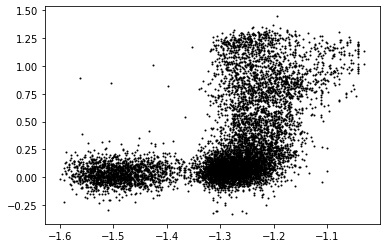

(0.503283510977267, 0.0)
SpearmanrResult(correlation=0.5902533939570932, pvalue=0.0)


In [ ]:
from scipy.stats import pearsonr, spearmanr
# plot the correlations

data_dir_out = '/content/drive/MyDrive/ex62_ta_design/protein_mpnn/'

df_scores = pd.read_csv(data_dir_out + '10pos_score.csv', header=None)
df_scores = df_scores.rename(columns={0:'seq',1:'score'})
print(df_scores.seq[0])

# get the mutkey from the sequence
df_scores['mutkey_m1'] = df_scores.apply(lambda r: get_mutkey_from_seq(r.seq, wt_mutkey), axis=1)
df_scores

#merge and plot
df_merge = df_10pos.merge(df_scores, left_on = 'muts_m1', right_on = 'mutkey_m1')
plt.figure()
plt.scatter( -df_merge.score, df_merge.mean_lrr_norm, s=1, c='black')
plt.show()
print(pearsonr(df_merge.mean_lrr_norm, -df_merge.score))
print(spearmanr(df_merge.mean_lrr_norm, -df_merge.score))

In [ ]:

df_merge.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'pre1', 'post1', 'rr1', 'lrr1', 'pre2',
       'post2', 'rr2', 'lrr2', 'pos_exp', 'muts', 'stop', 'wt', 'mean_lrr',
       'mean_lrr_norm', 'lrr1_norm', 'lrr2_norm', 'aa_mut_0', 'oh_pos0',
       'aa_mut_1', 'oh_pos1', 'aa_mut_2', 'oh_pos2', 'aa_mut_3', 'oh_pos3',
       'aa_mut_4', 'oh_pos4', 'aa_mut_5', 'oh_pos5', 'aa_mut_6', 'oh_pos6',
       'aa_mut_7', 'oh_pos7', 'aa_mut_8', 'oh_pos8', 'aa_mut_9', 'oh_pos9',
       'oh1', 'muts_m1', 'RES_pred', 'full_s_string', 'seq', 'score',
       'mutkey_m1'],
      dtype='object')


# generating sequences

# generating at diff T

## temperature gen

In [ ]:
# generating sequences for 10 position library only

print('generating sequences only for the 10 positions')

wt_seq = pdb_dict_list[0]['seq_chain_A']

n_seqs = 30
for t in [0.1, 0.3, 0.5, 0.7]:#[0.8, 0.9, 1.0, 1.1, 1.3, 1.4, 1.5]:#[1.2]:#[0.5, 1, 4]: #:
    full_gen_seq = generate_seqs(   dataset_valid,
                                    t,
                                    fixed_positions_dict_10pos_lib,
                                    1, # BATCH_COPIES --> how many to do at once
                                    n_seqs, # NUM_BATCHES --> number of sequences to generate
                                    device,
                                    chain_id_dict,
                                    omit_AA_dict,
                                    tied_positions_dict,
                                    pssm_dict,
                                    bias_by_res_dict,
                                    pssm_threshold,
                                    omit_AAs_np,
                                    bias_AAs_np,
                                    pssm_multi,
                                    pssm_log_odds_flag,
                                    pssm_bias_flag
                    )
    full_gen_seq
    print(' temp: {}, avg. hamming {}'.format(t, np.mean([hamming(s, wt_seq) for s in full_gen_seq])))
    write_seqs_fasta(full_gen_seq, '/content/drive/MyDrive/ex62_ta_design/protein_mpnn/t{}_ta_n{}_10x.fa'.format(t, n_seqs))

generating sequences only for the 10 positions
Generating sequences...
0
0
0
0
1
0
1
1
0
0
2
1
1
1
0
0
1
0
1
1
1
1
0
0
1
0
1
1
0
0
 temp: 0.1, avg. hamming 0.5333333333333333
Generating sequences...
1
1
3
2
2
2
1
1
1
2
1
0
2
2
0
1
2
1
2
0
1
2
1
0
1
1
2
1
1
1
 temp: 0.3, avg. hamming 1.2666666666666666
Generating sequences...
2
3
1
3
2
2
1
0
2
1
0
1
2
1
1
3
1
3
1
1
1
3
2
1
1
1
0
2
2
0
 temp: 0.5, avg. hamming 1.4666666666666666
Generating sequences...
3
4
2
4
4
3
1
3
4
2
2
2
2
4
4
3
4
5
4
2
2
4
2
3
2
2
2
1
2
4
 temp: 0.7, avg. hamming 2.8666666666666667


In [ ]:
# generate for a couple again to check variability
print('generating sequences only for the 10 positions')

wt_seq = pdb_dict_list[0]['seq_chain_A']

n_seqs = 30
for t in [1.0,1.2, 1.4]:#[0.1, 0.3, 0.5, 0.7]:#[0.8, 0.9, 1.0, 1.1, 1.3, 1.4, 1.5]:#[1.2]:#[0.5, 1, 4]: #:
    full_gen_seq = generate_seqs(   dataset_valid,
                                    t,
                                    fixed_positions_dict_10pos_lib,
                                    1, # BATCH_COPIES --> how many to do at once
                                    n_seqs, # NUM_BATCHES --> number of sequences to generate
                                    device,
                                    chain_id_dict,
                                    omit_AA_dict,
                                    tied_positions_dict,
                                    pssm_dict,
                                    bias_by_res_dict,
                                    pssm_threshold,
                                    omit_AAs_np,
                                    bias_AAs_np,
                                    pssm_multi,
                                    pssm_log_odds_flag,
                                    pssm_bias_flag
                    )
    full_gen_seq
    print(' temp: {}, avg. hamming {}'.format(t, np.mean([hamming(s, wt_seq) for s in full_gen_seq])))
    write_seqs_fasta(full_gen_seq, '/content/drive/MyDrive/ex62_ta_design/protein_mpnn/t{}_ta_n{}_10x_take2.fa'.format(t, n_seqs))

generating sequences only for the 10 positions
Generating sequences...
5
2
4
5
3
4
4
6
5
2
4
7
4
5
2
3
2
2
2
4
2
5
7
5
4
2
4
5
3
2
 temp: 1.0, avg. hamming 3.8
Generating sequences...
7
5
5
4
6
4
6
8
4
5
4
5
3
5
5
3
4
6
6
4
5
2
4
6
3
5
3
3
7
5
 temp: 1.2, avg. hamming 4.733333333333333
Generating sequences...
4
4
6
5
7
6
7
5
5
5
6
6
8
5
4
5
8
2
8
5
6
4
6
4
4
4
6
2
7
7
 temp: 1.4, avg. hamming 5.366666666666666


In [ ]:
# geerating for fixed N-terminus
# generate sequences using t [0.1, 0.3, 0.5, 0.7]
n_seqs = 30
for t in [0.1, 0.3, 0.5, 0.7]:
    print(t)
    full_gen_seq = generate_seqs(   dataset_valid,
                                    t,
                                    fixed_positions_dict_n_term,
                                    1, # BATCH_COPIES --> how many to do at once
                                    n_seqs, # NUM_BATCHES --> number of sequences to generate
                                    device,
                                    chain_id_dict,
                                    omit_AA_dict,
                                    tied_positions_dict,
                                    pssm_dict,
                                    bias_by_res_dict,
                                    pssm_threshold,
                                    omit_AAs_np,
                                    bias_AAs_np,
                                    pssm_multi,
                                    pssm_log_odds_flag,
                                    pssm_bias_flag
                    )
    full_gen_seq
    write_seqs_fasta(full_gen_seq, '/content/drive/MyDrive/ex62_ta_design/protein_mpnn/t{}_full_at_n{}_n_term_fixed.fa'.format(t, n_seqs))

In [ ]:
seq_keys = [k for k in pdb_dict_list[0].keys() if k.startswith('seq_chain')]
seq_key_to_seq = dict(zip(seq_keys, [pdb_dict_list[0][k] for k in seq_keys]))
for c, s in seq_key_to_seq.items():
    if c[-1] in ['A', 'C', 'E', 'G']:
        print(c, len(s))
        print(s)

seq_chain_G 85
ANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLT
seq_chain_E 85
NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTE
seq_chain_A 85
NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTE
seq_chain_C 85
ANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLT


In [ ]:
S_sample_concat.shape

(8, 748)

In [ ]:
print(len(wt_seq))
print(len(seq))

85
748


NVEKMEVNVTPEQAKWMKERVERGEYATESEIVEEALHSYELLKELEEDDIERLRRLWDEGKASGKPEPVDFDELRKEARERLEE
27
NVEKMLVNVTPEQAKEMKEWVEAGRYATESEIVNEALHSKELTLELEERDIETLRRLWDEGKASGKPEPVDFDELRKEALERLKE
30
NVEKMEVNVTPEQAKRMKELVEAGRYATRSEIVNEALHDYELTRELEERDIERLRELWDEGKASGEPEPVDFEELRKEALAALEK
29
NVEKMEVNVTPEQAKRMKEWVEAGRYATKSEIVREALHDYELTQELTEDDIRTLRRLWDEGKASGEPEPVDFEELRKEARARLEK
27
NVEKMEVNVTPEQAKEMKELVEAGKYATESEIVNEALHLYELTEKLTQDDIETLRRLWEEGKASGEPEPVDFEELRKEARERLKK
32
NVEKMEVNVTPEQAKRMREWVEAGRYATRSEIVEEALHQYELLRELEERDVERLRELWDEGKASGKPEPVDFRELREEARRRLER
30
NVEKMEVNVTPEQAKWMKERVEKGEYETESEIVREALHDYELLAELRERDIEELRRKWDEGKASGEPEPVDFEELRKEALKRLKK
31
NVEKMEVNVTPEQAKEMDELVEAGRYATRSEIVREALHSYQLLERLRQDDIEHLRRLWEEGLASGEPEPVDFEELRKEALERLKE
31
28
[('NVEKMEVNVTPEQAKWMKERVERGEYATESEIVEEALHSYELLKELEEDDIERLRRLWDEGKASGKPEPVDFDELRKEARERLEE', 'NVEKMLVNVTPEQAKEMKEWVEAGRYATESEIVNEALHSKELTLELEERDIETLRRLWDEGKASGKPEPVDFDELRKEALERLKE'), ('NVEKMEVNVTPEQAKWMKERVERGEYATESEIVEEALHSYELLKELEEDDIERLRRLWDEGKASGKPEPVDFDELRKEARERLEE', 'NVEKMEVNVTPEQ

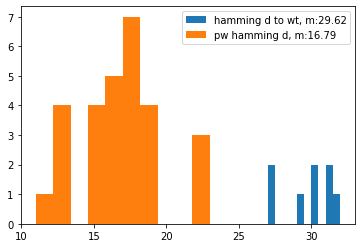

In [ ]:
from myPlot import plot_hammings

plot_hammings(designed_seqs, wt_seq)


In [ ]:
#@markdown ### Amino acid probabilties
import plotly.express as px
fig = px.imshow(np.exp(all_log_probs_concat).mean(0).T,
                labels=dict(x="positions", y="amino acids", color="probability"),
                y=list(alphabet),
                template="simple_white"
               )

fig.update_xaxes(side="top")


fig.show()

In [ ]:
#@markdown ### Sampling temperature adjusted amino acid probabilties
import plotly.express as px
fig = px.imshow(all_probs_concat.mean(0).T,
                labels=dict(x="positions", y="amino acids", color="probability"),
                y=list(alphabet),
                template="simple_white"
               )

fig.update_xaxes(side="top")


fig.show()

## misc generation

In [ ]:
# for 3 positions library need to icnreas temperature to get any mutations
# something like 0.7
pos3_gen_seq = generate_seqs(   dataset_valid,
                                1,
                                fixed_positions_dict_3pos_lib,
                                1, # BATCH_COPIES --> how many to do at once
                                100, # NUM_BATCHES --> number of sequences to generate
                                device, 
                                chain_id_dict, 
                                omit_AA_dict, 
                                tied_positions_dict, 
                                pssm_dict, 
                                bias_by_res_dict, 
                                pssm_threshold, 
                                omit_AAs_np,
                                bias_AAs_np,
                                pssm_multi,
                                pssm_log_odds_flag,
                                pssm_bias_flag
                  )
pos3_gen_seq
write_seqs_fasta(pos3_gen_seq, '/content/drive/MyDrive/ex62_ta_design/protein_mpnn/at_t1_3x.fa')

In [ ]:

# which positions are preferentially mutated?
pos10_gen_seq = generate_seqs(   dataset_valid,
                                2.0,
                                fixed_positions_dict,
                                1, # BATCH_COPIES --> how many to do at once
                                100, # NUM_BATCHES --> number of sequences to generate
                                device,
                                chain_id_dict,
                                omit_AA_dict,
                                tied_positions_dict,
                                pssm_dict,
                                bias_by_res_dict,
                                pssm_threshold,
                                omit_AAs_np,
                                bias_AAs_np,
                                pssm_multi,
                                pssm_log_odds_flag,
                                pssm_bias_flag
                  )
pos10_gen_seq
write_seqs_fasta(pos10_gen_seq, '/content/drive/MyDrive/ex62_ta_design/protein_mpnn/at_t2_10x_n100.fa')

In [ ]:
pos10_gen_seq = generate_seqs(   dataset_valid,
                                1,
                                fixed_positions_dict_10pos_lib,
                                1, # BATCH_COPIES --> how many to do at once
                                100, # NUM_BATCHES --> number of sequences to generate
                                device,
                                chain_id_dict,
                                omit_AA_dict,
                                tied_positions_dict,
                                pssm_dict,
                                bias_by_res_dict,
                                pssm_threshold,
                                omit_AAs_np,
                                bias_AAs_np,
                                pssm_multi,
                                pssm_log_odds_flag,
                                pssm_bias_flag
                  )
pos10_gen_seq
write_seqs_fasta(pos10_gen_seq, '/content/drive/MyDrive/ex62_ta_design/protein_mpnn/at_t1_10x.fa')

In [ ]:
# which positions are preferentially mutated?
full_gen_seq = generate_seqs(   dataset_valid,
                                2.0,
                                fixed_positions_dict,
                                1, # BATCH_COPIES --> how many to do at once
                                100, # NUM_BATCHES --> number of sequences to generate
                                device,
                                chain_id_dict,
                                omit_AA_dict,
                                tied_positions_dict,
                                pssm_dict,
                                bias_by_res_dict,
                                pssm_threshold,
                                omit_AAs_np,
                                bias_AAs_np,
                                pssm_multi,
                                pssm_log_odds_flag,
                                pssm_bias_flag
                  )
full_gen_seq
write_seqs_fasta(full_gen_seq, '/content/drive/MyDrive/ex62_ta_design/protein_mpnn/t2_full_at_n100.fa')

In [ ]:
# which positions are preferentially mutated?
full_gen_seq = generate_seqs(   dataset_valid,
                                1.0,
                                fixed_positions_dict,
                                1, # BATCH_COPIES --> how many to do at once
                                100, # NUM_BATCHES --> number of sequences to generate
                                device,
                                chain_id_dict,
                                omit_AA_dict,
                                tied_positions_dict,
                                pssm_dict,
                                bias_by_res_dict,
                                pssm_threshold,
                                omit_AAs_np,
                                bias_AAs_np,
                                pssm_multi,
                                pssm_log_odds_flag,
                                pssm_bias_flag
                  )
full_gen_seq
write_seqs_fasta(full_gen_seq, '/content/drive/MyDrive/ex62_ta_design/protein_mpnn/t1_full_at_n100.fa')

# misc

In [ ]:
# had to figure out which pdb file works, it needs a header

'''
##############################################
print('----pdb file from pdb: ----')
## parsing the chains
designed_chain = "A" #@param {type:"string"}
fixed_chain = "B,C,D" #@param {type:"string"}
if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")
if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")
chain_list = list(set(designed_chain_list + fixed_chain_list))

pdb_path = '/content/drive/MyDrive/ex62_ta_design/pdb_5cegs/5ceg_from_pdb.pdb1'
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)

print('pdb_dict_list',pdb_dict_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)
print(chain_id_dict)

for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")
'''
##############################################
print('----pdb file from pymol with modified header: ----')
## parsing the chains
designed_chain = "A" #@param {type:"string"}
fixed_chain = "B,C,D,E,F,G,H" #@param {type:"string"}
if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")
if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")
chain_list = list(set(designed_chain_list + fixed_chain_list))

pdb_path = '/content/drive/MyDrive/ex62_ta_design/pdb_5cegs/bio_all_rm_non_chain_dd1_header.pdb'
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)

print('pdb_dict_list',pdb_dict_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)
print(chain_id_dict)

for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

'''
# this does not work!
###############################################
print('----pdb file from pymol: ----')
#parsing the chains
designed_chain = "A" #@param {type:"string"}
fixed_chain = "B,C,D,E,F,G,H" #@param {type:"string"}
if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")
if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")
chain_list = list(set(designed_chain_list + fixed_chain_list))

pdb_path = '/content/drive/MyDrive/ex62_ta_design/pdb_5cegs/bio_all_rm_non_chain.pdb'
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])

print('pdb_dict_list',pdb_dict_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

print(chain_id_dict)
for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")
'''

----pdb file from pymol with modified header: ----
pdb_dict_list [{'seq_chain_A': 'NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTE', 'coords_chain_A': {'N_chain_A': [[-37.25, -65.728, -55.965], [-34.125, -65.642, -57.35], [-31.569, -63.119, -57.375], [-29.255, -61.601, -59.42], [-26.237, -59.74, -59.225], [-23.63, -57.423, -60.087], [-20.775, -56.868, -58.286], [-18.229, -54.942, -56.574], [-15.471, -55.912, -54.827], [-12.704, -55.829, -52.446], [-9.322, -56.786, -53.366], [-8.129, -58.321, -51.406], [-10.325, -59.211, -49.912], [-11.584, -60.773, -51.888], [-9.699, -62.738, -52.194], [-9.682, -64.134, -49.746], [-12.292, -65.07, -49.722], [-12.175, -66.826, -51.91], [-10.28, -68.64, -50.909], [-11.787, -69.759, -48.822], [-13.86, -71.034, -50.142], [-12.386, -72.858, -51.75], [-11.347, -74.435, -49.74], [-13.533, -75.794, -48.916], [-15.356, -74.751, -47.121], [-17.467, -73.314, -48.096], [-19.663, -73.499, -50.974], [-19.763, -71.699, -53.149], 

'\n# this does not work!\n###############################################\nprint(\'----pdb file from pymol: ----\')\n#parsing the chains\ndesigned_chain = "A" #@param {type:"string"}\nfixed_chain = "B,C,D,E,F,G,H" #@param {type:"string"}\nif designed_chain == "":\n  designed_chain_list = []\nelse:\n  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")\nif fixed_chain == "":\n  fixed_chain_list = []\nelse:\n  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")\nchain_list = list(set(designed_chain_list + fixed_chain_list))\n\npdb_path = \'/content/drive/MyDrive/ex62_ta_design/pdb_5cegs/bio_all_rm_non_chain.pdb\'\npdb_dict_list = parse_PDB(pdb_path, input_chain_list=[\'A\', \'B\', \'C\', \'D\', \'E\', \'F\', \'G\', \'H\'])\n\nprint(\'pdb_dict_list\',pdb_dict_list)\ndataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)\n\nchain_id_dict = {}\nchain_id_dict[pdb_dict_list[0][\'name\']]= (designed_chain_list, fixed_chain

3.0

In [ ]:
model = model.eval()
def test_fn(dataset_valid,
                fixed_positions_dict,
                BATCH_COPIES, 
                device, 
                chain_id_dict, 
                omit_AA_dict, 
                tied_positions_dict, 
                pssm_dict, 
                bias_by_res_dict, 
                pssm_threshold, 
                omit_AAs_np,
                bias_AAs_np,
                pssm_multi,
                pssm_log_odds_flag,
                pssm_bias_flag
                  ):
    '''
    returns a list of generated sequences that matches the wt sequence of that chain A
    '''
    with torch.no_grad():
        print('Generating sequences...')
        for ix, protein in enumerate(dataset_valid):
            score_list = []
            all_probs_list = []
            all_log_probs_list = []
            S_sample_list = []
            batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
            X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, 
                                                                                                                                                                                                                                                                                                                            device, 
                                                                                                                                                                                                                                                                                                                            chain_id_dict, 
                                                                                                                                                                                                                                                                                                                            fixed_positions_dict, 
                                                                                                                                                                                                                                                                                                                            omit_AA_dict, 
                                                                                                                                                                                                                                                                                                                            tied_positions_dict, 
                                                                                                                                                                                                                                                                                                                            pssm_dict, 
                                                                                                                                                                                                                                                                                                                            bias_by_res_dict)
            print(X,S)
            print(len(S.tolist()[0])) 
            print(len(mask.tolist()[0]))
            print(chain_M)
            print(chain_M_pos)
            print(chain_M*chain_M_pos)
            print(sum((mask*chain_M*chain_M_pos)[0]))

            pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
            name_ = batch_clones[0]['name']

            randn_1 = torch.randn(chain_M.shape, device=X.device)
            log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
            print(log_probs)
            print(log_probs.shape)

            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S, log_probs, mask_for_loss)

            alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
            #seq = ''.join([alphabet[c] for c in S[0]])
            seq= _S_to_seq(S[0],mask[0])
            print(seq)

            native_score = scores.cpu().data.numpy()

            print(native_score)

            randn_2 = torch.randn(chain_M.shape, device=X.device)

            sample_dict = model.tied_sample(X, 
                                            randn_2, 
                                            S, 
                                            chain_M, 
                                            chain_encoding_all, 
                                            residue_idx, 
                                            mask=mask, 
                                            temperature=1, 
                                            omit_AAs_np=omit_AAs_np, 
                                            bias_AAs_np=bias_AAs_np, 
                                            chain_M_pos=chain_M_pos, 
                                            omit_AA_mask=omit_AA_mask, 
                                            pssm_coef=pssm_coef, 
                                            pssm_bias=pssm_bias, 
                                            pssm_multi=pssm_multi, 
                                            pssm_log_odds_flag=bool(pssm_log_odds_flag), 
                                            pssm_log_odds_mask=pssm_log_odds_mask, 
                                            pssm_bias_flag=bool(pssm_bias_flag), 
                                            tied_pos=tied_pos_list_of_lists_list[0], 
                                            tied_beta=tied_beta, 
                                            bias_by_res=bias_by_res_all)
            S_sample = sample_dict["S"]
            print(S_sample)
            print(sample_dict)

test_fn(   dataset_valid,
            fixed_positions_dict_10pos_lib,
            1, # BATCH_COPIES --> how many to do at once
            device,
            chain_id_dict,
            omit_AA_dict,
            tied_positions_dict,
            pssm_dict,
            bias_by_res_dict,
            pssm_threshold,
            omit_AAs_np,
            bias_AAs_np,
            pssm_multi,
            pssm_log_odds_flag,
            pssm_bias_flag
        )

Generating sequences...
tensor([[[[-37.2500, -65.7280, -55.9650],
          [-36.2370, -66.5790, -56.5800],
          [-34.8040, -66.1130, -56.3100],
          [-34.3160, -66.2000, -55.1840]],

         [[-34.1250, -65.6420, -57.3500],
          [-32.7180, -65.2610, -57.2460],
          [-32.4320, -63.9430, -57.9590],
          [-32.9740, -63.6810, -59.0290]],

         [[-31.5690, -63.1190, -57.3750],
          [-31.1980, -61.8560, -57.9950],
          [-29.6950, -61.7440, -58.1740],
          [-28.9420, -61.7840, -57.2030]],

         ...,

         [[-20.3220, -69.2130, -31.0060],
          [-21.5830, -69.7250, -31.5610],
          [-21.6220, -71.2390, -31.4750],
          [-20.5790, -71.8730, -31.4080]],

         [[-22.8210, -71.8200, -31.5240],
          [-22.9390, -73.2810, -31.5570],
          [-22.6130, -73.8300, -32.9510],
          [-21.8680, -74.8100, -33.0820]],

         [[-23.1980, -73.2110, -33.9720],
          [-22.9200, -73.5320, -35.3730],
          [-22.7830, -72.23

In [ ]:
#@title Helper functions
def make_tied_positions_for_homomers(pdb_dict_list):
    my_dict = {}
    for result in pdb_dict_list:
        all_chain_list = sorted([item[-1:] for item in list(result) if item[:9]=='seq_chain']) #A, B, C, ...
        tied_positions_list = []
        chain_length = len(result[f"seq_chain_{all_chain_list[0]}"])
        for i in range(1,chain_length+1):
            temp_dict = {}
            for j, chain in enumerate(all_chain_list):
                temp_dict[chain] = [i] #needs to be a list
            tied_positions_list.append(temp_dict)
        my_dict[result['name']] = tied_positions_list
    return my_dict

import re
from google.colab import files
import numpy as np

#########################
def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  else:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
'''
def load_pdb_dd(fpath = '/content/drive/MyDrive/ex62_ta_design/bio_all_rm_non_chain.pdb'):
  from google.colab import drive
  drive.mount('/content/drive')
  #with open(fpath,"wb") as out: out.write(pdb_string)
  return "5ceg_all.pdb"
'''

'''
#@markdown ### Input Options
pdb='5ceg' #@param {type:"string"}
pdb_path = get_pdb(pdb)

'''
# loading own stuff
#pdb_path = load_pdb_dd() # loading my own stuff
from google.colab import drive
drive.mount('/content/drive')
pdb_path = '/content/drive/MyDrive/ex62_ta_design/bio_all_rm_non_chain.pdb'
#@markdown - pdb code (leave blank to get an upload prompt)


homomer = False #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "B,C,D,E,F,G,H" #@param {type:"string"}

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown ### Design Options
num_seqs = 1 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.
sampling_temp = "0.1" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]



save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True


##############################################################

folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
print('pdb_dict_list',pdb_dict_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

print(chain_id_dict)
for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

if homomer:
  tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
  tied_positions_dict = None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pdb_dict_list [{'name': 'bio_all_rm_non_chain', 'num_of_chains': 0, 'seq': ''}]
{'bio_all_rm_non_chain': (['A'], ['B', 'C', 'D', 'E', 'F', 'G', 'H'])}


KeyError: ignored